In [1]:
import torch 
from diffusers import AutoencoderKL

from networks.qwen import Qwen2Text_to_Image

dtype = torch.float16
device = 'cuda'
model = Qwen2Text_to_Image(
    pre_train_model='/huangzemin/niche/models/Qwen2-0.5B',
    tokenizer_path='/huangzemin/niche/models/Qwen2-0.5B',
    patch_size=2,
    img_size=32,
    
).to(device, dtype=dtype)

vae = AutoencoderKL.from_pretrained('/huangzemin/niche/models/sd-vae-ft-mse', torch_dtype=dtype)
vae.eval().requires_grad_(False).to(device)
pass

/root/envs/fetchA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/envs/fetchA/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
Some weights of Qwen2ForCausalLM were not initialized from the model checkpoint at /huangzemin/niche/models/Qwen2-0.5B and are newly initialized: ['model.layers.0.scale_shift_table', 'model.layers.1.scale_shift_table', 'model.layers.10.scale_shift_table', '

In [11]:
def ddp_module_name_clear(state_dict):
    final_weight = {}
    for key in state_dict:
        final_weight[key[7:]] = state_dict[key]
    return final_weight

# /huangzemin/tmp/training-state-062551.pt
ckpt = torch.load('/storage/huangzemin/lute/LLaMADiffusion/runs/00005-gpus8-batch48-bf16-Qwen-0.5B-Flow-Pre-train/training-state-205655.pt', map_location='cpu')
# model.load_state_dict(ddp_module_name_clear(ckpt['ema']), strict=False)
model.load_state_dict(ckpt['net'], strict=False)

<All keys matched successfully>

In [4]:
from tqdm import tqdm

@torch.no_grad()
def validation_step(
    net, 
    vae,
    prompts,
    dtype,
    sigma_max: float = 80.0,
    sigma_min: float = 0.002,
    rho: float = 7.0,
    val_denoising_step = 20,
    latent_size = 32,
    seed: int = 112
):
    torch.manual_seed(seed)
    device = 'cuda'
    bs = len(prompts)
    step_indices = torch.arange(val_denoising_step, device=device, dtype=dtype)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (val_denoising_step - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    
    latents = torch.randn(bs, 4, latent_size, latent_size, device=device, dtype=dtype)
    x_next = latents * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        t_cur = t_cur.view(1,).repeat(bs, )
        denoised = net(
            noisy_input=x_cur.to(dtype=dtype), 
            sigma_t=t_cur.to(dtype=dtype), 
            cond=prompts
        )
        
        t_cur = t_cur.view(-1, 1, 1, 1)
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur 
        
    latents = x_next / vae.config.scaling_factor
    image = vae.decode(latents, return_dict=False)[0]
    image = (image / 2 + 0.5).clamp(0, 1)
        
    return image


@torch.no_grad()
def validation_step_flow(
    net, 
    vae,
    prompt,
    dtype,
    sigma_max: float = 80.0,
    sigma_min: float = 0.002,
    rho: float = 7.0,
    val_denoising_step = 20,
    latent_size = 32,
    seed: int = 112,
    shift: float = 1.0,
    flow: bool = False,
    guidance_scale: float = 4.5
):
    torch.manual_seed(seed)
    device = 'cuda'
    bs = len(prompt)
    uncond = ["" for _ in range(bs)]
    
    if not flow:
        step_indices = torch.arange(val_denoising_step, device=device, dtype=dtype)
        t_steps = (sigma_max ** (1 / rho) + step_indices / (val_denoising_step - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
        t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    else:
        t_steps = torch.linspace(0, 1, val_denoising_step + 1, device=device, dtype=dtype)
        t_steps = shift * t_steps / (1 + (shift - 1) * t_steps)
        t_steps = t_steps.flip(dims=[0])
    
    latents = torch.randn(bs, 4, latent_size, latent_size, device=device, dtype=dtype)
    x_next = latents * t_steps[0]
    
    for i, (t_cur, t_next) in tqdm(enumerate(zip(t_steps[:-1], t_steps[1:])), total=val_denoising_step):
        x_cur = x_next
        t_cur = torch.tensor(t_cur).view(1,).repeat(bs, )
        
        cond_denoised = net(
            prompt,
            x_cur.to(dtype=dtype), 
            t_cur.to(dtype=dtype), 
            compute_text_loss=False,
        )
        
        uncond_denoised = net(
            uncond,
            x_cur.to(dtype=dtype), 
            t_cur.to(dtype=dtype), 
            compute_text_loss=False,
        )
        
        denoised = uncond_denoised + guidance_scale * (cond_denoised - uncond_denoised)
        
        t_cur = t_cur.view(-1, 1, 1, 1)
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur 
        
    latents = x_next / vae.config.scaling_factor
    image = vae.decode(latents, return_dict=False)[0]
    image = (image *.5 + .5).clamp(0, 1)
        
    return image

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_902/1603446813.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_cur = torch.tensor(t_cur).view(1,).repeat(bs, )
100%|██████████| 32/32 [00:04<00:00,  7.87it/s]


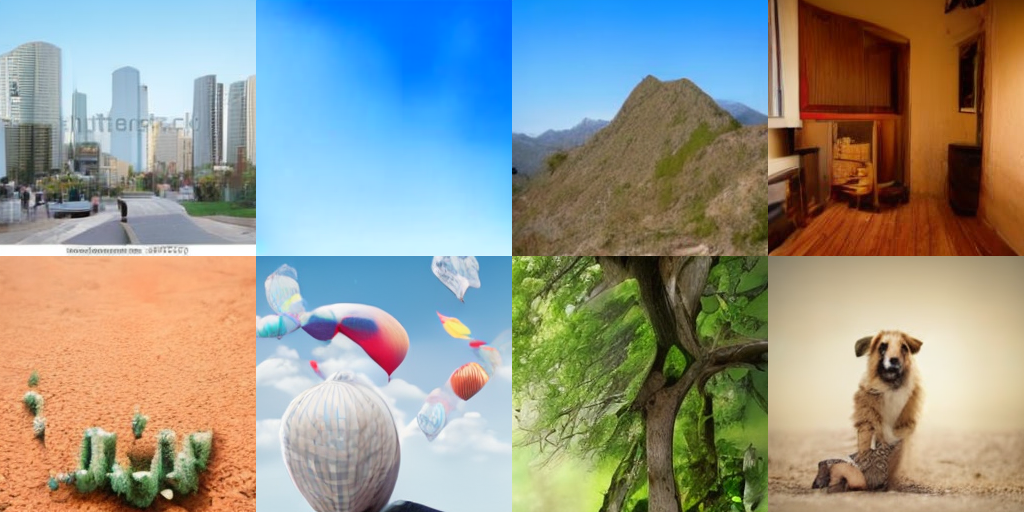

In [40]:
from PIL import Image
from torchvision.utils import make_grid
# prompts = [
    # "modern city", 
    # "a beautiful flower", 
    # "Astronaut in a jungle", 
    # "A snowymountain",
    # 'A small cactus in the desert',
    # 'a hot ballon',
    # "A bird sat on the tree",
    # "a dog is sitting in the sofa",
    
    # 'modern city',
    # 'A blue sky with clouds',
    # 'A small mountain',
    # 'A wooden room with a fireplace'
# ]

prompts = [
    'modern city', 
    'a blue sky with clouds',
    'a small mountain',
    'a wooden room with a fireplace',
    'A small cactus in the desert',
    'A hot ballon', 
    'A bird on the tree', 
    'A dog is sitting in the middle',
    # 'The image shows an aerial view of a spiral staircase in the middle of a forest. The staircase is surrounded by lush green grass and is situated in the center of the image',
    # 'The image shows a blue wall with a window box filled with purple flowers and lush green leaves. The window is framed by a white curtain, adding a touch of elegance to the scene.',
    # 'The image shows a group of people standing in front of a building, some of them holding guns and wearing masks. The sky is visible in the background, and there are vehicles on the left side of the image. The image is animated, giving it a dynamic feel.',
    # 'The image shows three women standing next to each other in dresses and hats, with one of them holding a bag. The background of the image is a wall, giving the impression of a great gatsby-style setting.'
]

seed = 224
step = '50k'
images = validation_step_flow(
    model, vae, prompts, dtype=dtype, 
    sigma_max=1.0,
    sigma_min=0.002,
    rho=7,
    val_denoising_step=32,
    latent_size = model.latent_size,
    shift=1.0,
    seed=seed, guidance_scale=4.5
)

images1 = make_grid(images, nrow=4, padding=0)
images1 = (images1 * 255).cpu().long().permute(1, 2, 0).numpy().round().astype("uint8")
# img_list = [img for img in images1]
comb_img = Image.fromarray(images1, 'RGB')
# comb_img.save(f'/huangzemin/lute/LLaMADiffusion/LLaMADiffusion/steps/{step}-{seed}.png')
comb_img.show()

# image: mean: ~0, std: 2.6-3.8
# text: mean: ~0, std: ~5
# tensor(-0.0001, device='cuda:0', dtype=torch.float16) tensor(0.0679, device='cuda:0', dtype=torch.float16)
# tensor(0.0003, device='cuda:0', dtype=torch.float16) tensor(0.8711, device='cuda:0', dtype=torch.float16)

In [13]:
tmp = torch.randn(8, 3, 64, 64)
out = make_grid(tmp, nrow=4)
print(out.shape)

torch.Size([3, 134, 266])


In [1]:
0.8711 / 0.0679

12.829160530191457

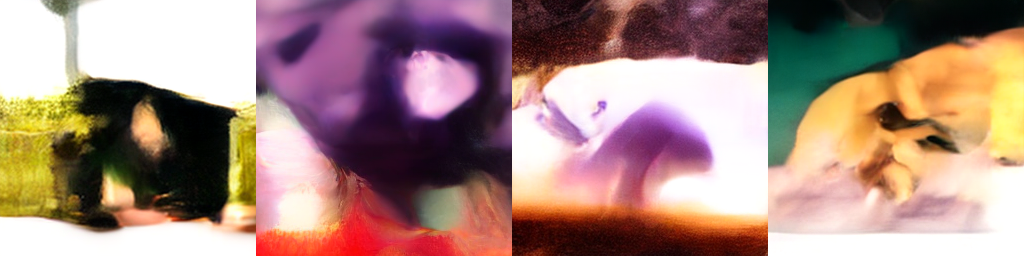

In [48]:
from PIL import Image
prompts = [
    # "A white horse in a storm of fire above the ocean",
    # 'A small cactus with a happy face in the Sahara desert',
    # 'Astronaut in a jungle, cold color palette, muted colors, detailed',
    # "nature vs human nature, surreal, UHD, 8k, hyper details, rich colors, photograph",
    "a dog is reading a thick book",
    'a beautiful flower',
    'Astronaut in a jungle, cold color palette, muted colors, detailed',
    "A snowymountain",
]

images = validation_step(
    model, vae, prompts, dtype=dtype, 
    sigma_max=80.0,
    sigma_min=0.002,
    rho=5,
    val_denoising_step=20,
    latent_size = model.latent_size,
    seed=128
)
images2 = (images * 255).cpu().long().permute(0, 2, 3, 1).numpy().round().astype("uint8")
img_list = [img for img in images2]
Image.fromarray(make_grid_4x4(img_list), 'RGB').show()
# image: mean: ~0, std: 2.6-3.8
# text: mean: ~0, std: ~5
# tensor(-0.0001, device='cuda:0', dtype=torch.float16) tensor(0.0679, device='cuda:0', dtype=torch.float16)

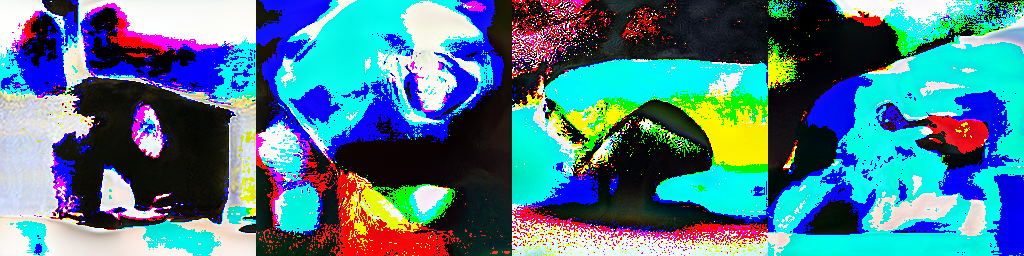

In [50]:
img_list = [img for img in (images1 - images2)]
Image.fromarray(make_grid_4x4(img_list), 'RGB').show()

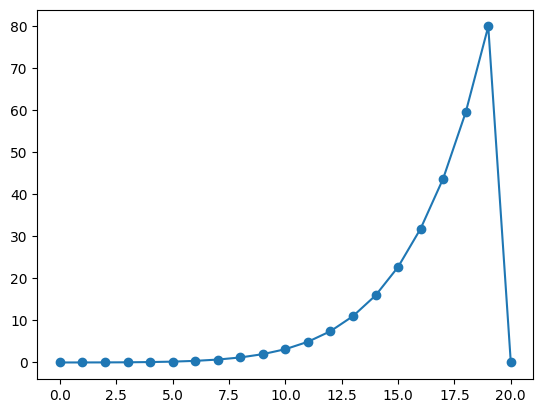

In [38]:
import matplotlib.pyplot as plt

sigma_max = 0.002 # 80
sigma_min = 80 # 0.002
val_denoising_step = 20
rho = 7

step_indices = torch.arange(val_denoising_step, device=device, dtype=dtype)
t_steps = (sigma_max ** (1 / rho) + step_indices / (val_denoising_step - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

plt.scatter(range(len(t_steps)), t_steps.cpu().numpy())
plt.plot(range(len(t_steps)), t_steps.cpu().numpy())

# Qwen2 Text-to-Image Test

In [1]:
# loading Model
import torch 
from networks.qwen import Qwen2Text_to_Image

dtype = torch.bfloat16
device = 'cuda'

model = Qwen2Text_to_Image(
    pre_train_model="/huangzemin/niche/models/Qwen2-0.5B",
    patch_size=2,
    img_size=32,
    img_channels=4,
    sigma_data=1.0
).to(device, dtype=dtype)

/root/envs/fetchA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Qwen2Model were not initialized from the model checkpoint at /huangzemin/niche/models/Qwen2-0.5B and are newly initialized: ['model.layers.0.scale_shift_table', 'model.layers.1.scale_shift_table', 'model.layers.10.scale_shift_table', 'model.layers.11.scale_shift_table', 'model.layers.12.scale_shift_table', 'model.layers.13.scale_shift_table', 'model.layers.14.scale_shift_table', 'model.layers.15.scale_shift_table', 'model.layers.16.scale_shift_table', 'model.layers.17.scale_shift_table', 'model.layers.18.scale_shift_table', 'model.layers.19.scale_shift_table', 'model.layers.2.scale_shift_table', 'model.layers.20.scale_shift_table', 'model.layers.21.scale_shift_table', 'model.layers.22.scale_shift_table', 'model.layers.23.sc

In [115]:
import torch 
import numpy as np
import torch.nn.functional as F

def _prepare_inputs(
    self,
    texts, 
    noisy_images: torch.Tensor,
    sigmas: torch.Tensor,
    max_text_len: int = 256
):
    B = len(texts)
    # combine text and image embeddings
    text_emb_list, seq_lens = self.compute_text_embs(texts, device=noisy_images.device, max_len=max_text_len)
    max_seq_len = max(seq_lens)

    img_embs = self.image_encoder(self.c_in(sigmas.view(-1, 1, 1, 1)) * noisy_images)
    
    # image pre & post token
    img_pre_embs = torch.stack([
        self.get_special_token_emb('eos', device=noisy_images.device),
        self.get_special_token_emb('boi', device=noisy_images.device)
    ], dim=1).repeat(B, 1, 1)
    # img_post_embs = self.get_special_token_emb(
    #     'eoi', device=noisy_images.device).view(1, 1, -1).repeat(B, 1, 1)
    img_embs = torch.concat([img_pre_embs, img_embs], dim=1)
    max_seq_len += img_embs.size(1)
    
    # join text and image embeddings and pad to equal length
    joint_embeds_list = []
    for ix, text_emb in enumerate(text_emb_list):
        joint_embs = torch.concat([text_emb.unsqueeze(dim=0), img_embs[ix:ix+1]], dim=1)
        joint_embeds_list.append(F.pad(
            joint_embs,
            pad=(0, 0, 0, max_seq_len - joint_embs.size(1)),
            mode='constant', value=0
        ))
    joint_embeds = torch.concat(joint_embeds_list, dim=0)
    print(joint_embeds.shape, max_seq_len)
    
    # enocde timestep
    temb0 = self.t_embed_layer(self.c_noise(sigmas)) # 
    temb1 = self.t_blocks(temb0)
    
    # create attention mask for joint sequence
    # first make a causal mask for text embeddings
    causal_mask = torch.triu(
        torch.ones(max_seq_len, max_seq_len, dtype=noisy_images.dtype, device=noisy_images.device), 
        diagonal=1
    ).view(1, 1, max_seq_len, max_seq_len).repeat(B, 1, 1, 1)
    bidirectional_mask = torch.ones_like(causal_mask)
    padding_mask = torch.zeros_like(causal_mask)
    img_token_len = img_embs.size(1) - 2 # exclude previous special tokens
    for ix, seq_len in enumerate(seq_lens):
        bidirectional_mask[ix, :, seq_len + 2: seq_len + 2 + img_token_len, seq_len + 2: seq_len + 2 + img_token_len] = 0.0
        padding_mask[ix, :, :, seq_len + 2 + img_token_len:] = 1.0
    attn_mask = torch.zeros_like(causal_mask)
    attn_mask.masked_fill_((causal_mask * bidirectional_mask + padding_mask) > 0.5, float("-inf"))
    image_mask = (1 - bidirectional_mask.long()).bool()
    
    return joint_embeds, temb0, temb1, attn_mask, image_mask, img_token_len, seq_lens

In [116]:
texts = [
    "a dog is reading a thick book", 
    "a beautiful flower", 
    "Astronaut in a jungle", 
    "A snowymountain"
]

noisy_images = torch.randn(4, 4, 32, 32, device=device, dtype=dtype)
sigmas = torch.randn(4, device=device, dtype=dtype)

with torch.no_grad():
    # denoised = model(texts, noisy_images, sigmas)
    B = len(texts)
    (
        joint_embeds, 
        temb0, temb1, 
        attn_mask, 
        image_mask,
        img_token_len,
        seq_lens
    ) = _prepare_inputs(model,
        texts=texts, 
        noisy_images=noisy_images,
        sigmas=sigmas,
        max_text_len=256
    )

torch.Size([4, 265, 896]) 265


In [97]:
causal_mask, bidirectional_mask, padding_mask = attn_mask
# print(bidirectional_mask.shape, padding_mask.shape)
print(padding_mask[2, 0])

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', dtype=torch.bfloat16)


In [77]:
def compute_position_ids(
    self, 
    text_len: int,
    img_hw,  
    seq_len: int,
    dtype,
    img_position_scale = (1, 1), # h, w
):
    text_x_id = torch.arange(text_len, dtype=dtype)
    text_y_id = text_x_id.clone()
    
    text_ids = torch.stack([text_x_id, text_y_id], dim=-1)
    
    img_x_id = torch.arange(0, img_hw[1], dtype=dtype)
    img_y_id = torch.arange(0, img_hw[0], dtype=dtype)
    img_ids = torch.stack(torch.meshgrid(img_y_id, img_x_id), dim=-1) # h, w, 2
    img_scales = torch.ones(1, 1, 2, dtype=dtype)
    img_scales[..., 0] = img_scales[..., 0] * img_position_scale[0]
    img_scales[..., 1] = img_scales[..., 1] * img_position_scale[1]
    img_offsets = torch.zeros(1, 1, 2, dtype=dtype) + text_len + .5 * img_hw[0] * img_hw[1]
    img_offsets[..., 0] = img_offsets[..., 0] - .5 * img_hw[0]
    img_offsets[..., 1] = img_offsets[..., 1] - .5 * img_hw[1]
    
    img_ids = (img_ids * img_scales + img_offsets).view(-1, 2)
    
    position_ids = torch.cat([text_ids, img_ids], dim=0)

    position_ids = F.pad(
        position_ids, 
        pad=(0, 0, 0, seq_len - position_ids.size(0)), 
        mode='constant', value=0)
    
    return position_ids

In [78]:
with torch.no_grad():
    position_ids = []
    for i in range(B):
        position_ids.append(
            compute_position_ids(model,
                text_len=seq_lens[i] + 2, # special token <eos> <boi> 
                img_hw=(noisy_images.size(-2) // 2, noisy_images.size(-1) // 2),
                seq_len=joint_embeds.size(1),
                dtype=noisy_images.dtype,
                img_position_scale=(1.0, 1.0)
            )
        )
    position_ids = torch.stack(position_ids, dim=0)

In [118]:
with torch.no_grad():
    output = model.model(
            inputs_embeds=joint_embeds,
            temb=temb1,
            image_mask=image_mask,
            attention_mask=attn_mask,
            position_ids=position_ids,
            return_dict=True
        )

IndexError: too many indices for tensor of dimension 3

In [2]:
from dataloaders.laion import load_laion_with_wds

dl = load_laion_with_wds(
    # data_dir='/storage/huangzemin/CC3M_subset',
    data_folder='/qiguojun/home/Dataset/laion_aes_recap_full',
    image_size=256,
    batch_size=2,
    num_workers=4
)

/root/envs/fetchA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
item = next(iter(dl))

In [7]:
item['prompts']

['The image shows Bill Cosby and his family standing together in a room with a wall in the background and lights on the ceiling. They are all smiling and posing for a photo.',
 'pink seashells on sand with some small shells in the background']

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/huangzemin/niche/models/Qwen2-0.5B")

/root/envs/fetchA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
a = tokenizer(
    "asdasd",
    max_length=128,
    # truncation=True,
    padding=True,
    return_tensors="pt",
)

/root/envs/fetchA/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [5]:

import torch.nn.functional as F
tokens = a['input_ids']
pad_tokens = F.pad(
        tokens, pad=(0, 2), mode='constant', value=0
    )
pad_tokens.shape

torch.Size([1, 5])

In [6]:
pad_tokens

tensor([[  300, 34889,    67,     0,     0]])